In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import IPython.html.widgets as wdg
import IPython.display as display

## The pulsed-gradient experiment: principles of dMRI signal formation

Diffusion MRI is a non-invasive method to measure the location- and direction-specific diffusion of water in the human brain *in vivo*. The measurement is rendered sensitive to diffusion through an application of a pulsed gradient, which is why the experiment is sometimes described as a Pulsed-Gradient Spin-Echo (or PGSE) experiment. Between the two gradients, a diffusion time is set, allowing water molecules to diffuse. The experiment is usually described through a diffusion sensitization parameter, called the b-value (possibly because it was first calculated by the French MRI scientist Denis Le-Bihan). This parameter summarizes several parameters of the measurement:

$b = \gamma^2 g^2 \delta ^2 (\Delta - \frac{\delta}{3})$ 

$\gamma$: the gyromagnetic ratio (42.576 $MHz$ for Hydrogen nuclei)

$g$: The amplitude of the gradient pulses

$\delta$: Duration of each gradient pulse

$\Delta$: the diffusion time (time between the first and second pulse) 

Except for $\gamma$, these are all experimentally controlled variables, so we can set the b value as we desire. The units of this quantity are typically reported in $\frac{s}{mm^2}$

Let's implement this as a function:

In [2]:
def b_value(g, delta, Delta, gamma=42.576):
    """ 
    Calculate the b value
    
    Parameters
    ----------
    g : gradient strength (mT/m, typically around 40)
    delta : gradient duration
    Delta : diffusion duration
    gamma : the gyromagnetic ration (42.576 MHz/T for Hydrogen)
    
    """
    G = g*1e-3*1e-6 #convert to T/um
    gamma = 2*np.pi*gamma*1e6*1e-3 # convert to 1/ms/T (Hz = cycles/sec, 1 cycle = 2pi = 2pi/sec)
    b = gamma ** 2 * G ** 2 * delta ** 2 * (Delta-delta/3) # millisecons/micrometer^2  
    return 1000 * b #s/mm^2

In the PGSE diffusion sensitization leads to loss of signal with increased diffusivity. This loss of signal can be described through the Stejskal-Tanner (Stejskal and Tanner, 1965) equation: 

$S(b, D) = S_0 e ^{-bD}$ 

Where b is the aformentioned diffusion sensitization parameter, and D is the coefficient of diffusion of the water molecules within the measurement voxel (in units of $\frac{mm^2}{s})$. When water is unrestricted, at 37 $^\circ$ C, this coefficient is equal to approximately 3.0 $\frac{mm^2}{s})$. This is the highest value we will ever see in the human brain, in the water-containing ventricles. Next, we will examine this equation: 

In [3]:
def ST_equation(b, D, S0=1):
    """ 
    The Stejskal Tanner equation
    """
    return S0 * np.exp(-b * D)

In [4]:
def viz_gradients(g = 40, delta = 13, Delta = 60):
    S0 = 1
    t = np.arange(0, 10 + delta + Delta + 10, 1) # In msec
    grad = np.zeros(t.shape)
    grad[np.where(np.logical_and(t>10, t<10 + delta))] = g
    grad[np.where(np.logical_and((t>10 + Delta), t <(10+Delta + delta)))] = g
    b = b_value(g, delta, Delta)
    fig, ax = plt.subplots(1, 2, tight_layout=True)
    ax[0].plot(t, grad)
    ax[0].plot([10, 10+delta], [g+10, g+10],'k-')
    ax[0].plot([10], [g+10],'k<')
    ax[0].plot([10+delta], [g+10],'k>')
    ax[0].text(10+delta/2., g+20, '$\delta$')
    ax[0].plot([10, 10+Delta], [g+40, g+40],'k-')
    ax[0].plot([10], [g+40],'k<')
    ax[0].plot([10+Delta], [g+40],'k>')
    ax[0].text(10+Delta/2., g+60, '$\Delta$')
    
    ax[0].plot([10+Delta+delta+5, 10+Delta+delta+5], [10, g],'k-')
    ax[0].plot([10+Delta+delta+5], [10],'kv')
    ax[0].plot([10+Delta+delta+5], [g],'k^')
    ax[0].text(10+Delta+delta+5+5, g/2., 'g')
    ax[0].set_ylabel('Gradient amplitude(mT/m)')
    ax[0].set_xlabel('Time (msec)')
    ax[0].set_xlim([-10, max(t) + 10])
    ax[0].set_ylim([-10, 375])
    D = np.arange(0, 4, 0.01)
    ax[1].plot(D, ST_equation(b/1000., D, S0=S0))
    ax[1].plot([3.0, 3.0], [0, S0], '--k')
    ax[1].set_xlabel(r'D ($\frac{mm^2}{s})$')
    ax[1].set_ylabel('MRI signal')
    ax[1].text(1, 0.8, 'b=%s'%int(b))

We will visualize the effect of 

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


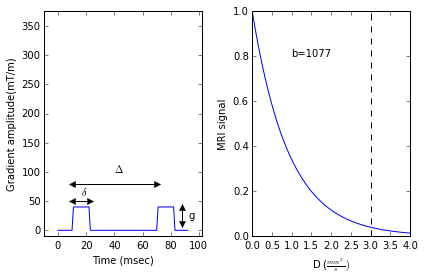

In [5]:
vg_widget = wdg.interactive(viz_gradients, 
                            g=wdg.FloatSliderWidget(min=10, max=300, step=10.0, value=40),
                            delta=wdg.FloatSliderWidget(min=10, max=40, step=1.0, value=13),
                            Delta=wdg.FloatSliderWidget(min=10, max=300, step=10.0, value=60)
                            )
display.display(vg_widget)

**NOTE:** This picture is somewhat idealized and not entirely realistic. For example, gradients take some time to ramp up to their peak level and there are other experimental considerations to take into account when considering what the b-value would be. But the principles still hold.

What are the consequences of different b-values on the measurement? As the b-value goes up two effects occur: on the one hand, the SNR of the measurement goes down. This is because the signal is proportional to a negative exponent of b:

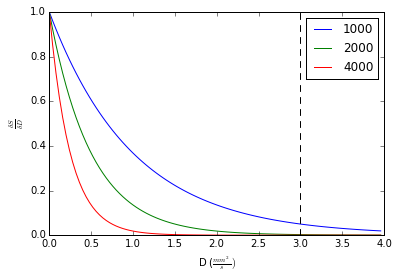

In [10]:
fig, ax = plt.subplots(1)
D = np.arange(0, 4, 0.04)
S0=1
b=1000
for b in [1000, 2000, 4000]:
    ST = ST_equation(b/1000., D, S0=S0)
    ax.plot(D, ST, label='%s'%b)
    ax.plot([3.0, 3.0], [0, S0], '--k')
    ax.set_xlabel(r'D ($\frac{mm^2}{s})$')
    ax.set_ylabel('$\\frac{\delta S}{\delta D} $')
plt.legend()

On the other hand, the sensitivity of the signal to changes in diffusuvity goes up. That is the derivative: $\frac{dS}{dD}$ goes up: 

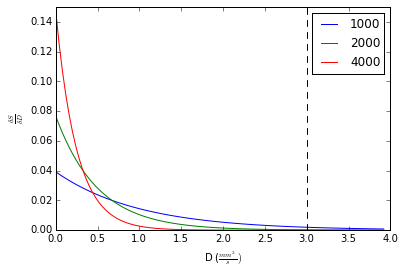

In [12]:
fig, ax = plt.subplots(1)
D = np.arange(0, 4, 0.04)
S0=1
b=1000
for b in [1000, 2000, 4000]:
    ST = ST_equation(b/1000., D, S0=S0)
    ax.plot(D[:-1], -np.diff(ST), label='%s'%b)
    ax.plot([3.0, 3.0], [0, S0], '--k')
    ax.set_xlabel(r'D ($\frac{mm^2}{s})$')
    ax.set_ylabel('$\\frac{\delta S}{\delta D} $')
    ax.set_ylim([0,0.15])
plt.legend()

The plot of the derivative of the signal as a function of diffusivity also demonstrates that the different b-values each have a range of diffusivities for which this b-value has the most sensitivity.